In [38]:
import dal, pandas, common, numpy
dal.init_db()
common.PERIODS_IN_HOUR = 4*60
common.PERIODS_IN_DAY = common.PERIODS_IN_HOUR * 24
from scipy.stats import multivariate_normal
from sklearn import model_selection
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [17]:
all_sessions = dal.get_ended_sessions()

In [47]:
def calc_prob(row):
    global model
    return  model.pdf((row['sessions_durations'], row['sessions_bandwidths']))

def my_log(x):
    if isinstance(x, (int, long, float, complex)):
        return common.safe_log(common.safe_log(x))
    else:
        return x

def get_script_data(data):
    bots_ips = ['10.0.0.2','10.0.0.21','10.0.0.6','10.0.0.14','10.0.0.3', '88.198.23.221', '10.0.0.20', '10.0.0.12', '10.0.0.11',  '10.0.0.23', '10.0.0.18',  '10.0.0.24', '10.0.0.105',  '10.0.0.5', '10.0.0.104']
    data.drop(data[(data['dest_ip'].isin(bots_ips) | data['src_ip'].isin(bots_ips))== False].index, inplace=True)

def get_human_data(data):
    bots_ips = ['10.0.0.2','10.0.0.21','10.0.0.6','10.0.0.14','10.0.0.3', '88.198.23.221', '10.0.0.20', '10.0.0.12', '10.0.0.11',  '10.0.0.23', '10.0.0.18',  '10.0.0.24', '10.0.0.105',  '10.0.0.5', '10.0.0.104']
    data.drop(data[(data['dest_ip'].isin(bots_ips) | data['src_ip'].isin(bots_ips))].index, inplace=True)


In [4]:
def get_hours_kpis(all_kpis):
    from collections import defaultdict

    # get sorted by timestamp from mongo

    current_ts = all_kpis[0]['timestamp'] - 5 * common.seconds_in_day
    current_hour = 9
    kpis_by_hours = defaultdict(list)

    for i in range(24):
        kpis_by_hours[current_hour] += filter(
            lambda x: current_ts > x['timestamp'] > current_ts - common.seconds_in_hour, all_kpis)
        current_ts -= common.seconds_in_hour
        current_hour -= 1
        if current_hour == -1:
            current_hour = 23
            #         all_kpis = filter(lambda x: x['timestamp'] < current_ts, all_kpis)

    return kpis_by_hours

In [57]:
df = get_hours_kpis(all_sessions)

In [64]:
for i in df:
    df[i] =  pandas.DataFrame(df[i])
    df[i] = df[i].drop(df[i][df[i]['dest_ip'].str.match("10.0.*") == False].index)
    


In [59]:
for i in df:
    get_human_data(df[i])

In [62]:
for i in df:
    data = pandas.DataFrame()
    data['sessions_bandwidths'] = df[i]['n_bytes']
    data['sessions_durations'] = df[i]['timestamp'] - df[i]['start_time']
    data['dest_ip'] = df[i]['dest_ip']
    data['src_ip'] = df[i]['src_ip']
    df[i] = data

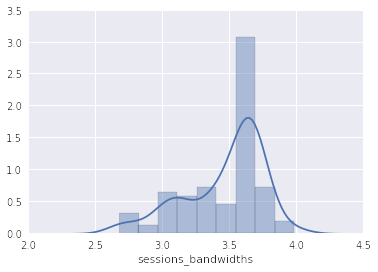

In [71]:
x = df[14]['sessions_bandwidths'].apply(lambda x: my_log(x))
sns.distplot(x, hist=True)
